In [1]:
%pylab inline
%config InlineBackend.figure_format = 'retina'

from astropy.table import Table
import daft
import exoplanet as xo
import numpy as np
import pandas as pd
import pymc3 as pm
import pymc3_ext as pmx
import seaborn as sns
import theano.tensor as T
import scipy.stats as ss

sns.set_context('notebook')
sns.set_palette('colorblind')
sns.set_style('ticks')

Populating the interactive namespace from numpy and matplotlib


# Problem N1

Let us start solving the exercises $1-5$; as an introduction for $6$ and $7$ .

## Exercise 1:

Let us read the information from the table 1.

In [2]:
df = pd.read_csv("table1.txt", sep=' ')

xs = df['x'][4:19].to_numpy()
ys_obs = df['y'][4:19].to_numpy()
sigma_y = df['sigma_y'][4:19].to_numpy()

According to the equation (5), the best linear fit parameters $(m,b)$ for the data points $(x_i,y_i)$ are: 
$$\begin{bmatrix} m\\
b
\end{bmatrix}
=X=[A^TC^{-1}A]^{-1} [A^TC^{-1}Y]$$
where:

$$Y=\begin{bmatrix} y_1\\
y_2\\
\vdots\\
y_n
\end{bmatrix},
\hspace{1cm}
A=\begin{bmatrix} 1 & x_1\\
1 & x_2\\
\vdots & \vdots\\
1 & x_n
\end{bmatrix},  
\hspace{1cm} C=\begin{bmatrix} 
\sigma_{y1}^2 & 0 & \cdots & 0\\
0 & \sigma_{y2} & \cdots & 0\\
 &\cdots \\
 0 & 0 & \cdots & \sigma_{n1}^2
 \end{bmatrix}$$




In [3]:
Y = ys_obs
A = np.array([ones_like(xs), xs]).T
C = diag(sigma_y**2)

P = matmul(A.T, linalg.inv(C))
X1 = linalg.inv(matmul(P, A))
X2 = matmul(P, Y)
X = matmul(X1, X2)

xs_obs = linspace(0,300, 100)
ys_true = X[1]*xs_obs + X[0]

print(X)

[36.18781935  2.2326614 ]


(0.0, 700.0)

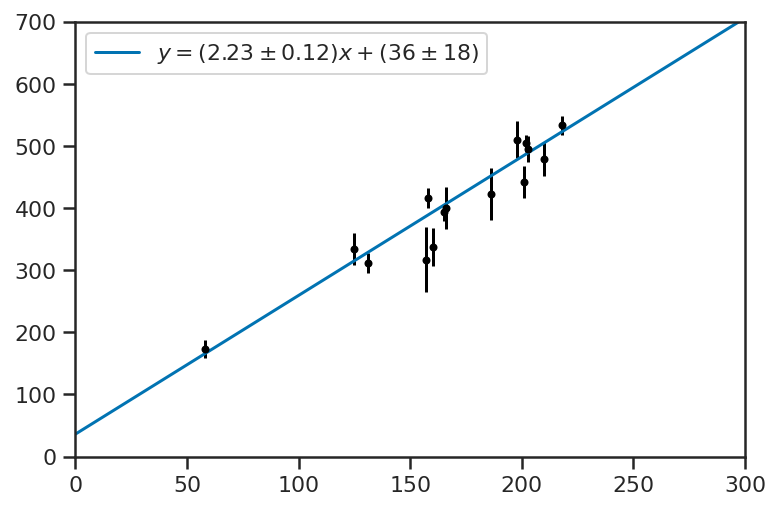

In [4]:
errorbar(xs, ys_obs, yerr=sigma_y, color='black', fmt='.')
plot(xs_obs, ys_true, label=r'$y=(2.23 \pm 0.12)x+(36 \pm 18)$')
legend()
xlim([0, 300])
ylim([0, 700])


From the definition made before, is important to remark that $[A^TC^{-1}A]^{-1}$ is the covariant matrix of the parameters in $X$. From here the, computed $\sigma_m^2$ is the $(2,2)$ element of the previous matrix

In [97]:
print(X1)

[[ 1.55388546e+03 -2.23563932e+01  7.32865068e-02]
 [-2.23563932e+01  3.55985601e-01 -1.23426449e-03]
 [ 7.32865068e-02 -1.23426449e-03  4.42482621e-06]]


From this Matrix we may compute the variance of $\sigma_m^2$ given by: `1.16988991e-02`

## Exercise 2:

Now, let us repeat the Exercise 1, but with all the data in the table.

In [98]:
xs = df['x'].to_numpy()
ys_obs = df['y'].to_numpy()
sigma_y = df['sigma_y'].to_numpy()

Y = ys_obs
A = np.array([ones_like(xs), xs]).T
C = diag(sigma_y**2)

P = matmul(A.T, linalg.inv(C))
X1 = linalg.inv(matmul(P, A))
X2 = matmul(P, Y)
X = matmul(X1, X2)

xs_obs = linspace(0,300, 100)
ys_true = X[1]*xs_obs + X[0]

print(X)
print(X1)

[213.27349198   1.07674752]
[[ 2.07188189e+02 -1.05427206e+00]
 [-1.05427206e+00  5.99181008e-03]]


(0.0, 700.0)

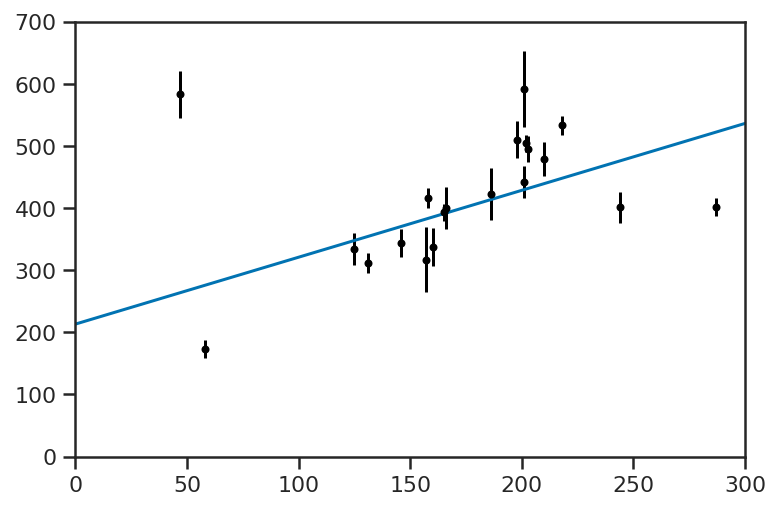

In [7]:
errorbar(xs, ys_obs, yerr=sigma_y, color='black', fmt='.')
plot(xs_obs, ys_true, label=r'$y=(1.08\pm0.08)x+(213\pm 14) $')
xlim([0, 300])
ylim([0, 700])

and the variance of $\sigma_m^2$: `5.99e-03`

There are two things, I don't like of this result:
1. The variance $\sigma_m^2$ has decreased after incorporating all the values in the table; however, all the points are are now more scattered. 
2. The value of $b$ changed dramatically after incorporating all the changes.

We can see comparing both plots, that the new points are quite far appart from the linear fit.

## Exercise 3:

Let us modify $A$, by introducing a column of values $x_i^2$, and another element in $X$, denoted by $q$.

In [8]:
df = pd.read_csv("table1.txt", sep=' ')

xs = df['x'][4:19].to_numpy()
ys_obs = df['y'][4:19].to_numpy()
sigma_y = df['sigma_y'][4:19].to_numpy()

In [99]:
Y = ys_obs
A = np.array([ones_like(xs), xs, xs**2]).T
C = diag(sigma_y**2)

P = matmul(A.T, linalg.inv(C))
X1 = linalg.inv(matmul(P, A))
X2 = matmul(P, Y)
X = matmul(X1, X2)

print(X)
print(X1)

[ 1.88458350e+01  3.71596602e+00 -7.80681914e-03]
[[ 7.36083772e+02 -8.23365705e+00  2.12366503e-02]
 [-8.23365705e+00  1.03446904e-01 -2.88272569e-04]
 [ 2.12366503e-02 -2.88272569e-04  8.52711443e-07]]


(0.0, 700.0)

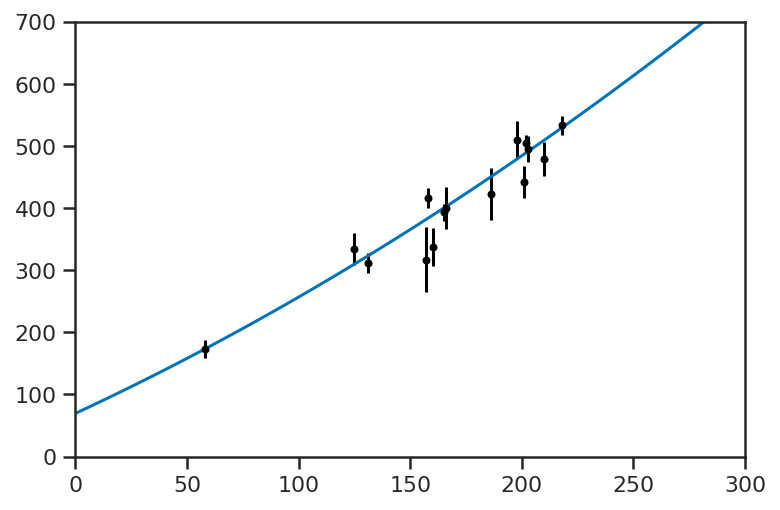

In [10]:
xs_obs = linspace(0, 300, 100)
ys_true = X[2]*xs_obs**2 + X[1]*xs_obs + X[0]

errorbar(xs, ys_obs, yerr=sigma_y, color='black', fmt='.')
plot(xs_obs, ys_true)
xlim([0, 300])
ylim([0, 700])

## Exercise 6

Let us start by storing the information of the Table 1 in appropiate working variables, and plotting them

Text(0, 0.5, '$y_\\mathrm{obs}$')

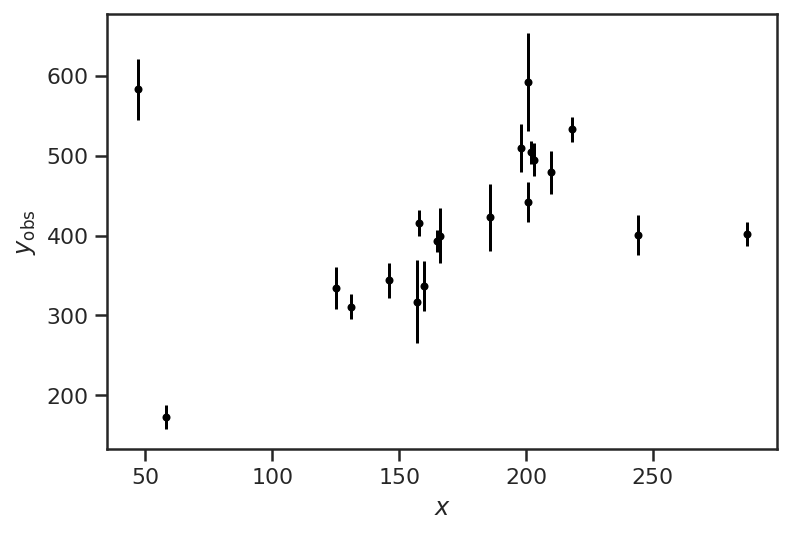

In [11]:
df = pd.read_csv("table1.txt", sep=' ')
xs = df['x'].to_numpy()
ys_obs = df['y'].to_numpy()
sigma_y = df['sigma_y'].to_numpy()

errorbar(xs, ys_obs, yerr=sigma_y, color='black', fmt='.')
xlabel(r'$x$')
ylabel(r'$y_\mathrm{obs}$')

In [12]:
with pm.Model() as mixture:

    m = pm.Normal('m', mu = 2, sigma = 2)
    b = pm.Normal('b', mu=100, sigma=200)

    Y_e = pm.Normal('Y_e', mu = 400, sigma = 200)
    V_e= pm.Lognormal('V_e', mu=log(200), sigma =log(200))

    P_bad = pm.Beta('P_bad', alpha=6, beta=14)

    ys_true = pm.Deterministic('ys_true', m*xs + b) 
    _ = pm.Mixture('ys_obs', [1-P_bad, P_bad],[pm.Normal.dist(mu=ys_true, sigma= sigma_y), pm.Normal.dist(mu=Y_e*ones_like(ys_obs), sigma=V_e)], observed=ys_obs)

<ipython-input-43-a54f4a252a00>:2: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  mix_trace = pm.sample(draws = 1000, tune = 1000)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [P_bad, V_e, Y_e, b, m]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 6 seconds.


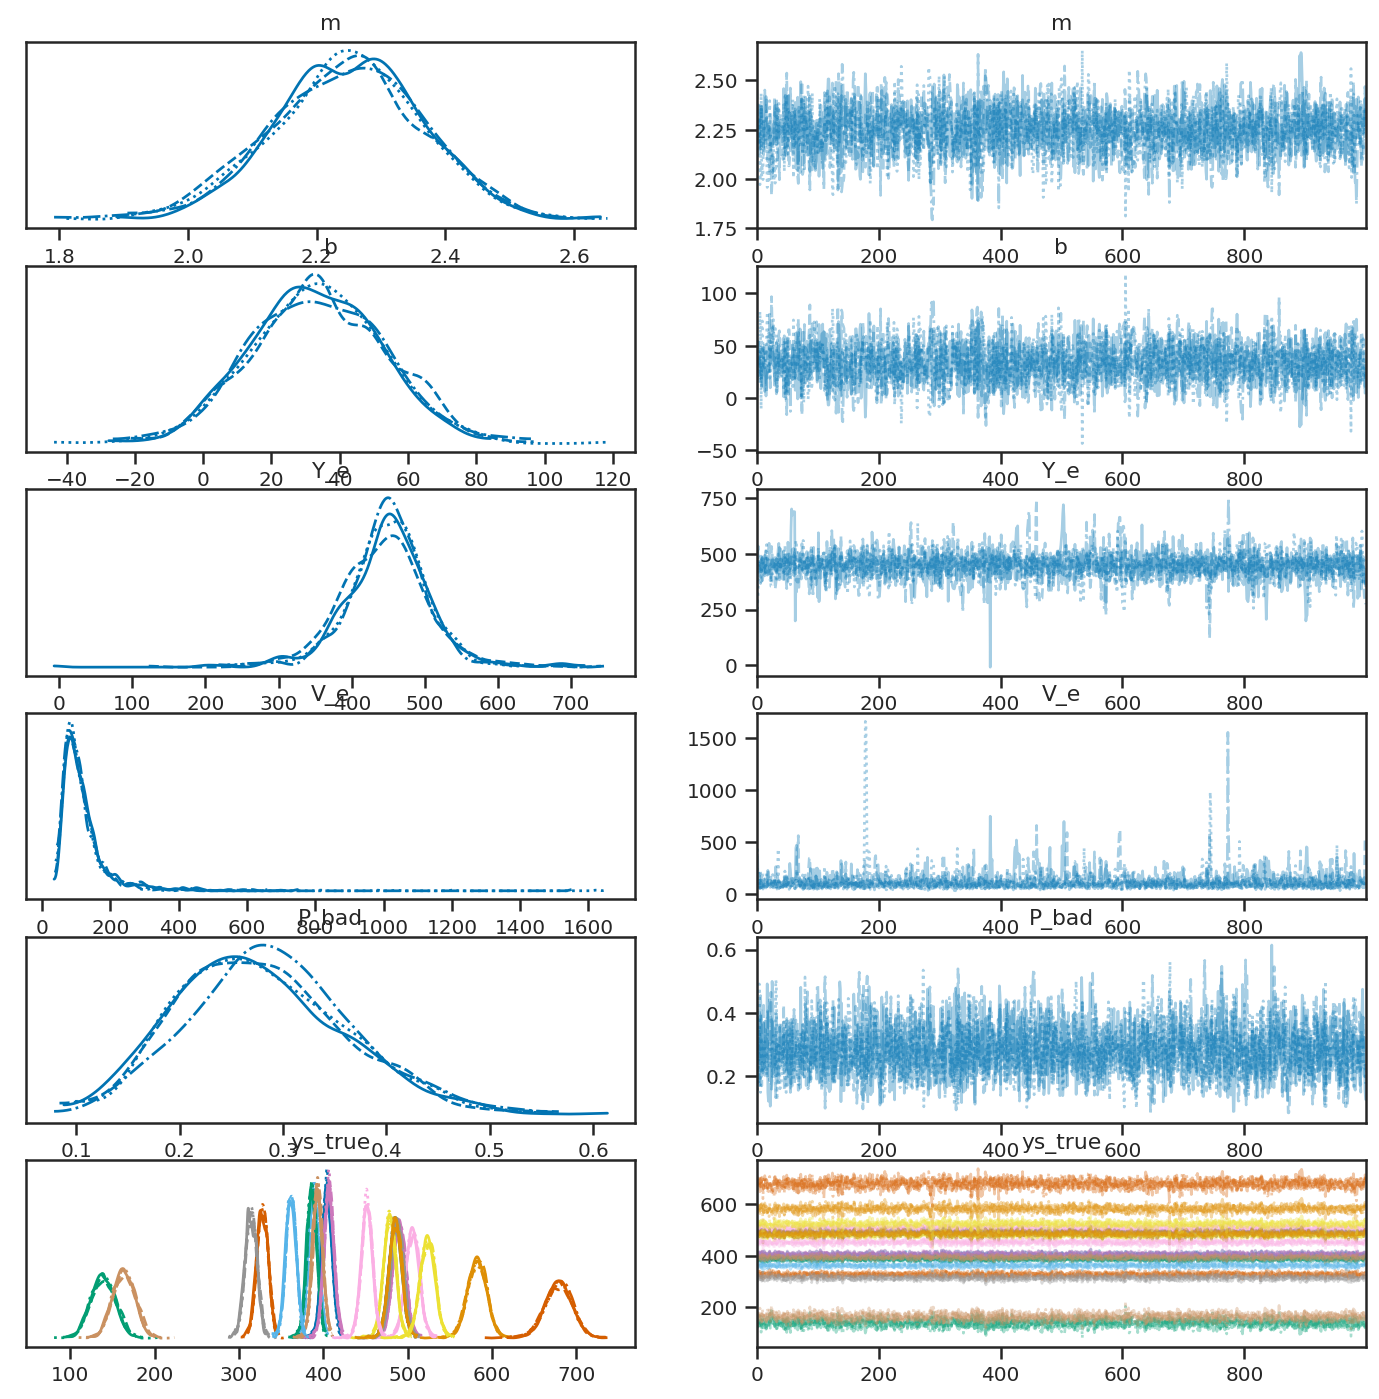

In [43]:
with mixture:
    mix_trace = pm.sample(draws = 1000, tune = 1000)
    pm.plot_trace(mix_trace)

Text(0.5, 1.0, 'Full posterior Distribution')

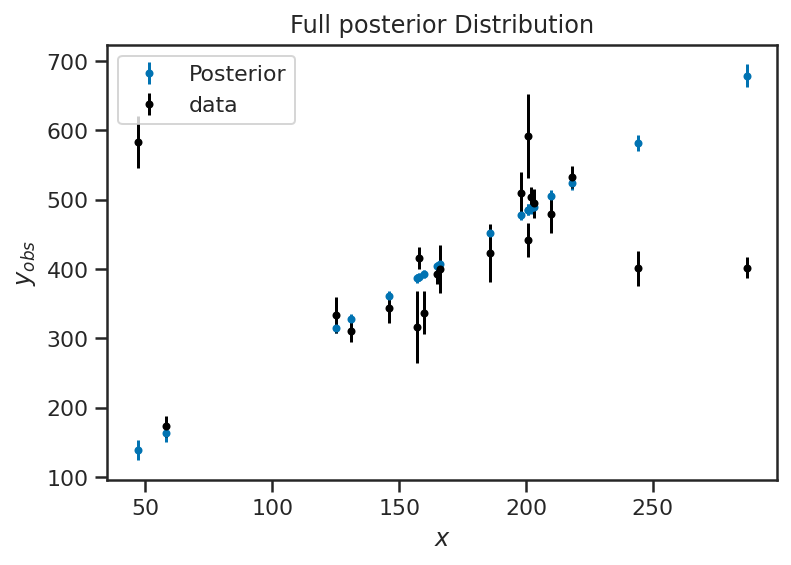

In [44]:
errorbar(xs, mean(mix_trace['ys_true'], axis=0), yerr=std(mix_trace['ys_true'], axis=0), fmt='.', label=r'Posterior')
errorbar(xs, ys_obs, yerr=sigma_y, color='black', fmt='.', label='data')
xlabel(r'$x$')
ylabel(r'$y_{obs}$')
legend(loc='best')
title(r'Full posterior Distribution')

From this plot, we can see a good estimate of the linear regression. However, is important to recall that we have plotted the full posterior without marginalizing over the $P_\mathrm{bad}$, $Y_e$ and $V_e$. Therefore, after marginalizing over $P_\mathrm{bad}$, $Y_e$ and $V_e$, we get the subspace $(b,m)$. Furthermore, using a kernel density estimator, we have drawn different contours to localize a zone of maximum density where the MAP is localized. 

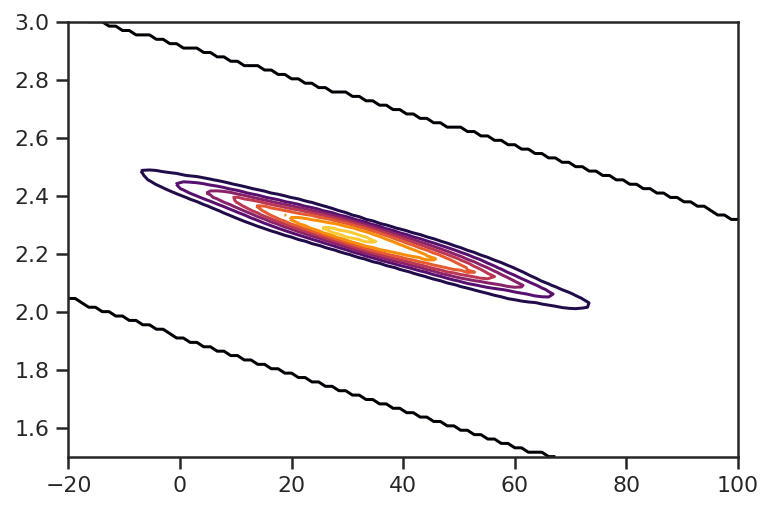

In [95]:
with mixture:
    bs, ms = mix_trace['b'], mix_trace['m']
    kde = ss.gaussian_kde(vstack((bs, ms)))

    b = linspace(-20, 100, 100)
    m = linspace(1.5, 3, 100)
    B, M = meshgrid(b, m, indexing='ij')
    density = kde(vstack((B.flatten(), M.flatten()))).reshape(M.shape)

    #pm.plot_pair(mix_trace, var_names=['b', 'm'])
    contour(B, M, density, cmap='inferno')

Finally, computing the MAP estimate and plotting samples from the neighboors:

28.484848484848484 2.2727272727272725


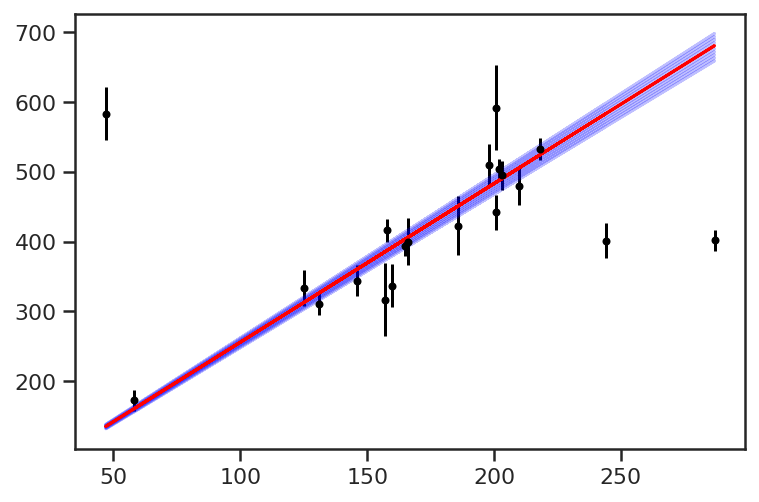

In [96]:
i_max = argmax(density) 
errorbar(xs, ys_obs, yerr=sigma_y, color='black', fmt='.', label='data')

for k in range(-5,5):
    if k != 0:
        plot(xs, M.ravel()[i_max+k]*xs + B.ravel()[i_max+k], color='blue', alpha=0.25)

plot(xs, M.ravel()[i_max]*xs + B.ravel()[i_max], color='red', alpha=1.0)

print(B.ravel()[i_max], M.ravel()[i_max])

The MAP line in comparison with fit defined in the exercise 2, is definitely a better fit.

## Exercise 7

Now we will provide the $P_\mathrm{bad}$ distribution from the fully marginalized posterior except $P_\mathrm{bad}$:

In [117]:
with pm.Model() as mixture2:

    m = pm.Normal('m', mu = 2, sigma = 2)
    b = pm.Normal('b', mu=100, sigma=200)

    Y_e = pm.Normal('Y_e', mu = 400, sigma = 200)
    V_e= pm.Lognormal('V_e', mu=log(200), sigma =log(200))

    P_bad = pm.Beta('P_bad', alpha=6, beta=14)

    ys_true = pm.Deterministic('ys_true', m*xs + b) 
    _ = pm.Mixture('ys_obs', [1-P_bad, P_bad],[pm.Normal.dist(mu=ys_true, sigma= sigma_y/2.0), pm.Normal.dist(mu=Y_e*ones_like(ys_obs), sigma=V_e)], observed=ys_obs)

In [119]:
with mixture2:
    mix_trace2 = pm.sample(draws = 1000, tune = 1000)

<ipython-input-119-0622f2313d7b>:2: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  mix_trace2 = pm.sample(draws = 1000, tune = 1000)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [P_bad, V_e, Y_e, b, m]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 11 seconds.
The acceptance probability does not match the target. It is 0.6582336643059012, but should be close to 0.8. Try to increase the number of tuning steps.
The estimated number of effective samples is smaller than 200 for some parameters.


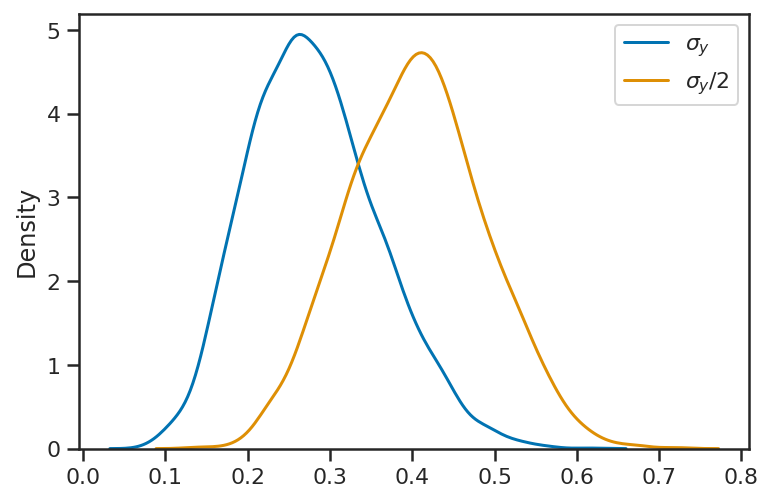

In [125]:
sns.kdeplot(mix_trace['P_bad'], label=r'$\sigma_y$')
sns.kdeplot(mix_trace2['P_bad'], label=r'$\sigma_y/2$')
legend()

# Problem N2

Let us start opening the data, which contains three important fields: `JD` which is the Julian Day Calendar time $t$ where the observations were taken, the `Radial_Velocity` field which measure $v_r$ and finally the measurements uncertainties in `Radial_Velocity_Uncertainty`.

In [22]:
fopeg_data = Table.read('ButlerEtAl200651PegUID_0113357_RVC_001.tbl.txt', format='ascii')
fopeg_data

tmid = median(fopeg_data['JD'])

Now, we want to define a function to plot the data with its uncertainty, over the whole day-domain or fold the whole domain over the period, in case we know it.

In [23]:
def plot_data(P=None, **kwargs):
    if P is None:
        ts = fopeg_data['JD'] - tmid
        xlabel(r'$(t-t_\mathrm{mid})$')

    else:
        ts = (fopeg_data['JD'] - tmid)%P

    errorbar(ts, fopeg_data['Radial_Velocity'], yerr=fopeg_data['Radial_Velocity_Uncertainty'], fmt='.', **kwargs)
    ylabel(r'$v_r / \mathrm{m} \mathrm{s}^{-1}$')

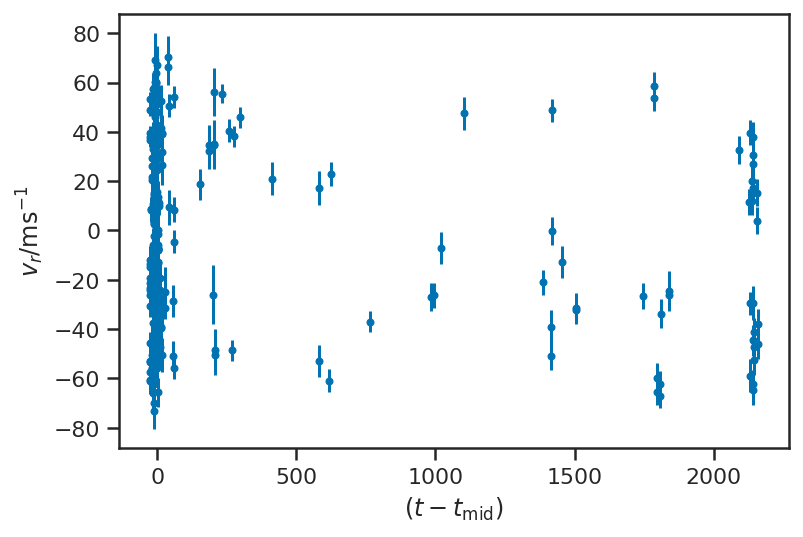

In [24]:
plot_data()